In [8]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!pip install scikit-fuzzy

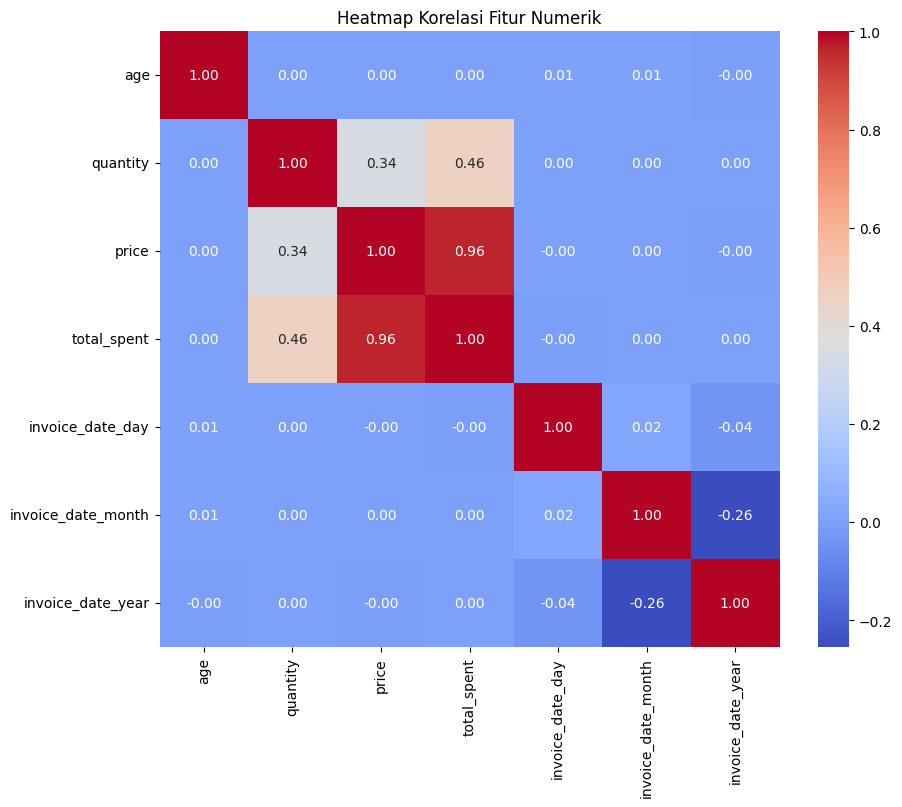

   c       FPC  Silhouette   XieBeni
0  3  0.551964    0.308700  0.309156
1  4  0.506114    0.324222  0.208063
2  5  0.473739    0.343876  0.174555
3  6  0.450908    0.353360  0.186786


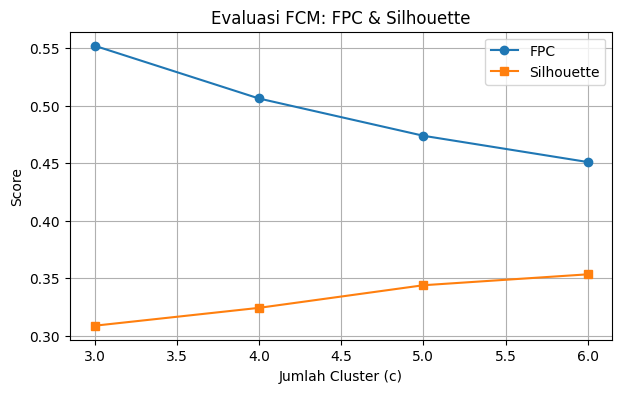

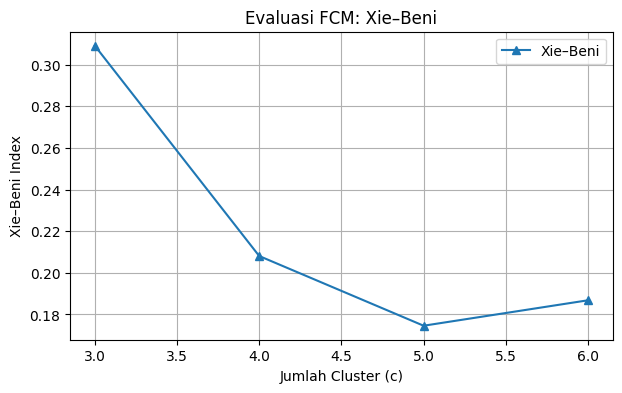

Best cluster (c): 5
FPC full data: 0.4746429600361337
Silhouette full data: 0.3448694519274556


'/content/drive/MyDrive/MATKUL_ELEKTRONIK/customer_fcm_best_model.csv'

In [11]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import skfuzzy as fuzz

# load data
path = "/content/drive/MyDrive/MATKUL_ELEKTRONIK/customer_shopping_data.csv"
df = pd.read_csv(path)

# drop kolom id
df = df.drop(columns=['invoice_no', 'customer_id'])

# preprocessing tanggal
df['invoice_date_time'] = pd.to_datetime(df['invoice_date'], dayfirst=True)
df['invoice_date_day'] = df['invoice_date_time'].dt.day
df['invoice_date_month'] = df['invoice_date_time'].dt.month
df['invoice_date_year'] = df['invoice_date_time'].dt.year
df.drop('invoice_date', axis=1, inplace=True)

# feature engineering total_spent
df['total_spent'] = df['quantity'] * df['price']

# korelasi fitur numerik
numeric_cols = [
    'age',
    'quantity',
    'price',
    'total_spent',
    'invoice_date_day',
    'invoice_date_month',
    'invoice_date_year'
]

corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap Korelasi Fitur Numerik")
plt.show()

# pilih fitur final clustering
features = ['age', 'quantity', 'total_spent']
X = df[features].copy()

# scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# sampling untuk evaluasi jumlah cluster
np.random.seed(42)
sample_size = 30000
idx_sample = np.random.choice(len(X_scaled), sample_size, replace=False)

X_sample = X_scaled[idx_sample]
X_fcm_sample = X_sample.T

# fungsi Xie–Beni Index
def xie_beni_index(X, cntr, u, m=2.0):
    n = X.shape[0]
    diff = X[None, :, :] - cntr[:, None, :]
    dist2 = np.sum(diff ** 2, axis=2)
    num = np.sum((u ** m) * dist2)

    center_diff = cntr[:, None, :] - cntr[None, :, :]
    center_dist2 = np.sum(center_diff ** 2, axis=2)
    np.fill_diagonal(center_dist2, np.inf)
    min_center_dist2 = np.min(center_dist2)

    return num / (n * min_center_dist2)

# evaluasi jumlah cluster (FPC, Silhouette, Xie–Beni)
m = 2
results = []

for c_test in range(3, 7):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_fcm_sample,
        c=c_test,
        m=m,
        error=0.005,
        maxiter=500,
        init=None,
        seed=42
    )

    labels = np.argmax(u, axis=0)
    sil = silhouette_score(X_sample, labels)
    xb = xie_beni_index(X_sample, cntr, u, m=m)

    results.append((c_test, fpc, sil, xb))

results_df = pd.DataFrame(
    results,
    columns=['c', 'FPC', 'Silhouette', 'XieBeni']
)

print(results_df)

# plot evaluasi
plt.figure(figsize=(7,4))
plt.plot(results_df['c'], results_df['FPC'], marker='o', label='FPC')
plt.plot(results_df['c'], results_df['Silhouette'], marker='s', label='Silhouette')
plt.xlabel('Jumlah Cluster (c)')
plt.ylabel('Score')
plt.title('Evaluasi FCM: FPC & Silhouette')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7,4))
plt.plot(results_df['c'], results_df['XieBeni'], marker='^', label='Xie–Beni')
plt.xlabel('Jumlah Cluster (c)')
plt.ylabel('Xie–Beni Index')
plt.title('Evaluasi FCM: Xie–Beni')
plt.grid(True)
plt.legend()
plt.show()

# tentukan best cluster berdasarkan Xie–Beni minimum
best_row = results_df.loc[results_df['XieBeni'].idxmin()]
best_c = int(best_row['c'])

print("Best cluster (c):", best_c)

# clustering final full data
X_fcm = X_scaled.T

cntr, u, u0, d, jm, p, fpc_full = fuzz.cluster.cmeans(
    X_fcm,
    c=best_c,
    m=m,
    error=0.005,
    maxiter=1000,
    init=None,
    seed=42
)

df['cluster'] = np.argmax(u, axis=0)

# evaluasi final
sil_full = silhouette_score(X_scaled, df['cluster'])
print("FPC full data:", fpc_full)
print("Silhouette full data:", sil_full)

# simpan hasil ke csv
output_path = "/content/drive/MyDrive/MATKUL_ELEKTRONIK/customer_fcm_best_model.csv"
df.to_csv(output_path, index=False)

output_path
